In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][1] #0

# load data
# mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat',thetaFiltered='thetaFiltered.lfp.mat')
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


load *SessionPulses.Events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/spk_beh_df.p saved!


In [370]:
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117'

In [3]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_key='v',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [4]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [5]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [6]:
reload(pa)

<module 'place_cell_analysis' from '/mnt/home/szheng/projects/util_code/place_cell_analysis.py'>

In [7]:
all_fields_all_trialtype=pd.concat(pf_res['avg']['all_fields'],axis=0)

fr_map_concat,index_within_to_trial_index_df = pa.concat_fr_map_trial_df_d(fr_map_trial_df_d,spk_beh_df)

# problem in 159 of pa: sometimes fr_map_trial_df_d has fewer trials because of bad 

In [267]:
# reload(dpp)
# trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)
# index_within_to_trial_index_df = trial_index_to_index_within_df.reset_index(level=2).set_index('index',append=True)['trial_ind'].astype(int)

In [8]:

reload(dpp)
reload(pca)
reload(cpacas)


task_ind = 0
all_fields = all_fields_all_trialtype.loc[task_ind]

fr_key = 'fr_peak'
pf_fr = pd.concat(pf_res['avg']['params'],axis=0).loc[(slice(None),slice(None),fr_key),:]
index=pf_fr.index.droplevel(2)
pf_fr.index=index
pf_fr = pf_fr.loc[task_ind]

changes_df_both_trialtype = switch_res['avg']['changes_df'].loc[task_ind,slice(None),0.3,'switch_magnitude',0.4]

res = cpacas.switch_detection_combined(pf_res, all_fields, pf_fr, index_within_to_trial_index_df, spk_beh_df, changes_df_both_trialtype=changes_df_both_trialtype,task_ind=0)



INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
all_sw_times_v_combined= res['all_sw_times_v_combined']
all_fields_times_v=res['all_fields_times_v']
pf_all_field_combined = res['pf_all_field_combined']

In [10]:
beh_vars = ['v','lin_binned','theta_phase','theta_amp','trial']

In [35]:
reload(cpacas)

<module 'change_point_analysis_central_arm_seperate' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis_central_arm_seperate.py'>

In [11]:
sw_beh_df = cpacas.switch_count_with_beh_var_over_time(all_sw_times_v_combined,spk_beh_df,task_index=0,beh_vars = ['v','lin_binned','lin','x','y','theta_phase','theta_amp','trial'])



/mnt/home/szheng/projects/nmf_analysis/change_point_analysis_central_arm_seperate.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sw_beh_df[onoff] = count
/mnt/home/szheng/projects/nmf_analysis/change_point_analysis_central_arm_seperate.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sw_beh_df[onoff] = count


In [149]:
reload(cpacas)
sw_triggered_pods2d_d=cpacas.switch_count_by_pos2d(sw_beh_df)

In [159]:
count,edges_x,edges_y=np.histogram2d(sw_triggered_pods2d_d[1]['x'],sw_triggered_pods2d_d[1]['y'],bins=10)


In [162]:
sw_triggered_pods2d_d

{1:                      x          y
 6648.309700  77.409262  45.670877
 6649.543333  56.823908  45.316718
 6649.943467  42.703216  45.117742
 6683.752033  55.872619  44.754616
 6684.052100  42.590247  45.480281
 ...                ...        ...
 8202.503967  28.881221  82.322790
 8202.503967  28.881221  82.322790
 8206.171567  77.045811  82.193240
 8206.171567  77.045811  82.193240
 8206.171567  77.045811  82.193240
 
 [313 rows x 2 columns],
 -1:                      x          y
 6650.710300  19.495828  44.702841
 6651.043733  11.276205  45.407341
 6683.685333  58.743337  44.401691
 6685.019000  18.767616  44.025183
 6686.152633   9.459134  51.407592
 ...                ...        ...
 7965.610533  76.768341  82.661515
 7965.610533  76.768341  82.661515
 7965.610533  76.768341  82.661515
 8051.532333  77.006259  82.233626
 8051.532333  77.006259  82.233626
 
 [210 rows x 2 columns]}

In [169]:
spk_beh_df

,1,2,3,4,5,6,7,8,9,10,...,speed,visitedArm,direction,correct,v,theta_phase,theta_amp,theta_data,trial_type,lin_binned
Time (s),,,,,,,,,,,,,,,,,,,,,
6596.563233,1,3,2,1,0,3,2,0,3,2,...,0.000000,NaN,0,NaN,NaN,0.771996,647.350491,463.792443,None,4
6596.596600,1,1,2,2,3,2,1,0,4,1,...,0.013457,NaN,0,NaN,NaN,2.637343,529.478917,-463.431780,None,4
6596.629933,0,0,3,0,2,0,4,1,2,0,...,0.026912,NaN,0,NaN,NaN,-1.667300,405.380783,-39.079901,None,4
6596.663267,1,1,3,1,1,3,2,0,1,0,...,0.040332,NaN,0,NaN,NaN,0.544824,326.928684,279.527708,None,4
6596.696600,1,1,1,0,2,1,2,1,3,0,...,0.053686,NaN,0,NaN,NaN,2.833718,389.842228,-371.403080,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8438.263767,1,0,0,0,3,0,1,1,5,1,...,0.924964,1.0,1,1.0,NaN,0.700314,1112.252634,850.332873,"(0, 1.0)",98
8438.297133,2,2,1,1,3,1,2,2,3,1,...,0.741925,1.0,1,1.0,NaN,2.455421,938.987070,-726.413572,"(0, 1.0)",98
8438.330467,0,1,1,0,1,1,3,0,1,0,...,0.557586,1.0,1,1.0,NaN,-2.040790,790.979421,-358.171021,"(0, 1.0)",98


In [170]:
edges_y

array([ 4.43706824, 12.50340281, 20.56973738, 28.63607195, 36.70240652,
       44.76874109, 52.83507566, 60.90141022, 68.96774479, 77.03407936,
       85.10041393])

({1: array([[ 1., 10.,  6.,  3.,  1., 23.,  6., 11., 10.,  8.],
         [ 9.,  0.,  0.,  0.,  1.,  9.,  0.,  0.,  0.,  7.],
         [ 6.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  0.,  1.],
         [ 1.,  0.,  0.,  0.,  4.,  3.,  0.,  0.,  0.,  7.],
         [ 3.,  0.,  0.,  0.,  3.,  6.,  0.,  0.,  0.,  7.],
         [ 4.,  0.,  0.,  0.,  1.,  6.,  0.,  0.,  0.,  3.],
         [ 4.,  0.,  0.,  0.,  4.,  9.,  0.,  0.,  0.,  1.],
         [ 4.,  0.,  0.,  0.,  1., 10.,  0.,  0.,  0., 14.],
         [ 5.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0., 12.],
         [ 1.,  3., 14.,  2.,  0.,  0.,  0., 23.,  4., 13.]]),
  -1: array([[ 2.,  5.,  3.,  4., 20.,  7.,  3.,  7.,  8.,  4.],
         [ 4.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  4.],
         [ 1.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  4.],
         [ 0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.],
         [ 2.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  1.],
         [ 0., 

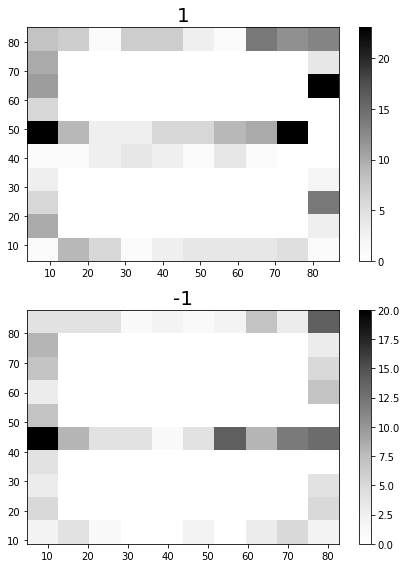

In [193]:
reload(cpacas)
cpacas.switch_count_by_pos2d(sw_beh_df,bins=10,doplot=True)

> /mnt/home/szheng/projects/nmf_analysis/change_point_analysis_central_arm_seperate.py(318)get_total_pf_per_pos_bin()
    316     gpb=spk_beh_df.groupby('trial_type')
    317     pf_xy_trialtype = {}
--> 318     for (tsk_ind,tt_ind), val in gpb:
    319 
    320         if task_ind==task_ind: # for now just do one task_ind

ipdb> n
> /mnt/home/szheng/projects/nmf_analysis/change_point_analysis_central_arm_seperate.py(320)get_total_pf_per_pos_bin()
    318     for (tsk_ind,tt_ind), val in gpb:
    319 
--> 320         if task_ind==task_ind: # for now just do one task_ind
    321             val['lin_binned']
    322             lin_binned = val['lin_binned'].values

ipdb> n
> /mnt/home/szheng/projects/nmf_analysis/change_point_analysis_central_arm_seperate.py(321)get_total_pf_per_pos_bin()
    319 
    320         if task_ind==task_ind: # for now just do one task_ind
--> 321             val['lin_binned']
    322             lin_binned = val['lin_binned'].values
    323             xy = 

(array([[21., 10., 21., 11., 16., 49., 12., 15., 18., 22.],
        [11.,  0.,  0.,  0.,  8., 13.,  0.,  0.,  0.,  7.],
        [ 8.,  0.,  0.,  0.,  8.,  5.,  0.,  0.,  0., 10.],
        [ 7.,  0.,  0.,  0.,  5.,  8.,  0.,  0.,  0., 12.],
        [ 7.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  8.],
        [11.,  0.,  0.,  0.,  2., 12.,  0.,  0.,  0.,  4.],
        [ 9.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  7.],
        [ 3.,  0.,  0.,  0.,  0., 17.,  0.,  0.,  0., 21.],
        [ 8.,  0.,  0.,  0.,  0., 26.,  2.,  0.,  0.,  8.],
        [11., 13.,  1., 24.,  0.,  5.,  0., 26.,  9., 22.]]),
 array([ 7.3047384 , 14.87587924, 22.44702008, 30.01816092, 37.58930176,
        45.1604426 , 52.73158344, 60.30272428, 67.87386512, 75.44500596,
        83.0161468 ]),
 array([ 5.81853902, 13.60966989, 21.40080075, 29.19193161, 36.98306248,
        44.77419334, 52.5653242 , 60.35645507, 68.14758593, 75.93871679,
        83.72984766]),
 <Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'ce

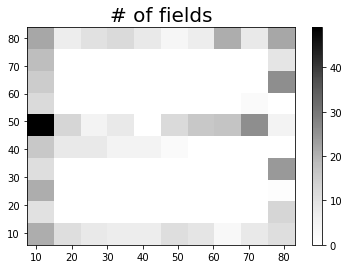

In [222]:
reload(cpacas)
cpacas.get_total_pf_per_pos_bin(pf_all_field_combined,spk_beh_df,bins=10,task_ind=0,pos_key='peak',doplot=True)




(array([[ 1., 10.,  6.,  3.,  1., 23.,  6., 11., 10.,  8.],
        [ 9.,  0.,  0.,  0.,  1.,  9.,  0.,  0.,  0.,  7.],
        [ 6.,  0.,  0.,  0.,  3.,  3.,  0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  0.,  4.,  3.,  0.,  0.,  0.,  7.],
        [ 3.,  0.,  0.,  0.,  3.,  6.,  0.,  0.,  0.,  7.],
        [ 4.,  0.,  0.,  0.,  1.,  6.,  0.,  0.,  0.,  3.],
        [ 4.,  0.,  0.,  0.,  4.,  9.,  0.,  0.,  0.,  1.],
        [ 4.,  0.,  0.,  0.,  1., 10.,  0.,  0.,  0., 14.],
        [ 5.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0., 12.],
        [ 1.,  3., 14.,  2.,  0.,  0.,  0., 23.,  4., 13.]]),
 array([ 3.78292708, 12.12416567, 20.46540426, 28.80664286, 37.14788145,
        45.48912004, 53.83035864, 62.17159723, 70.51283582, 78.85407442,
        87.19531301]),
 array([ 4.43706824, 12.50340281, 20.56973738, 28.63607195, 36.70240652,
        44.76874109, 52.83507566, 60.90141022, 68.96774479, 77.03407936,
        85.10041393]),
 <matplotlib.collections.QuadMesh at 0x155459a8cb80>)

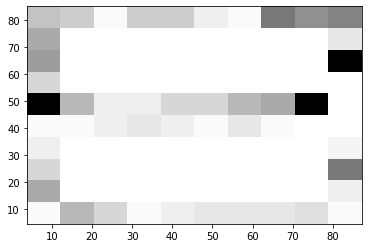

In [182]:
plt.hist2d(sw_triggered_pods2d_d[1]['x'],sw_triggered_pods2d_d[1]['y'],bins=10)

(array([[ 2.,  5.,  3.,  4., 20.,  7.,  3.,  7.,  8.,  4.],
        [ 4.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  4.],
        [ 1.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  4.],
        [ 0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.],
        [ 2.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  2.],
        [ 3.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  7.],
        [ 5.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  3.],
        [ 2.,  5.,  4.,  0., 13.,  0.,  7.,  5.,  3., 14.]]),
 array([ 4.85879462, 12.6561617 , 20.45352878, 28.25089585, 36.04826293,
        43.84563001, 51.64299709, 59.44036417, 67.23773125, 75.03509832,
        82.8324654 ]),
 array([ 8.84997352, 16.75890348, 24.66783344, 32.5767634 , 40.48569336,
        48.39462332, 56.30355328, 64.21248324, 72.1214132 , 80.03034316,
        87.93927312]),
 <matplotlib.collections.QuadMesh at 0x155459f71160>)

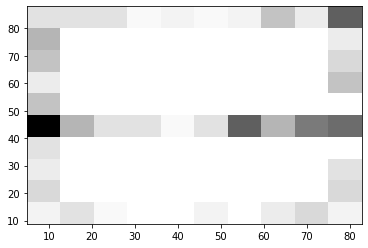

In [179]:
plt.hist2d(sw_triggered_pods2d_d[-1]['x'],sw_triggered_pods2d_d[-1]['y'],bins=10)

In [43]:
import patsy
from patsy import dmatrix

In [76]:
sw_beh_df=sw_beh_df.dropna(axis=0)

In [81]:
# x=sw_beh_df['v'].dropna()
y= dmatrix("bs(lin_binned, df=6, degree=3, include_intercept=True)+bs(v, df=6, degree=3, include_intercept=True)", data=sw_beh_df)




In [103]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

ImportError: cannot import name 'GLM' from 'statsmodels.gam.api' (/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/statsmodels/gam/api.py)

In [119]:
beh_var = ['v','lin_binned','theta_phase','theta_amp','trial']
sw_beh_df_sub =pd.concat([sw_beh_df[beh_var].rolling(100).mean()[::50].dropna(axis=0),
                          sw_beh_df[[1,-1]].rolling(100).sum()[::50].dropna(axis=0)
                         ]
                         ,axis=1) 


<AxesSubplot:xlabel='Time (s)'>

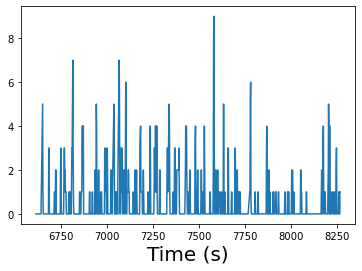

In [121]:
sw_beh_df_sub[1].plot()

In [111]:
df[1].unique()

array([ 0.,  3.,  4.,  5.,  2.,  1.,  6.,  7.,  8.,  9., 10., 11.])

Time (s)
6614.334433    True
6614.367767    True
6614.401100    True
6614.434433    True
6614.467800    True
               ... 
8266.420200    True
8266.453533    True
8266.486867    True
8266.520200    True
8266.553567    True
Name: 1, Length: 47187, dtype: bool

In [132]:
df = sw_beh_df_sub
df=df.loc[df[1]<=1]
# x_spline=sw_beh_df[['lin_binned','v']]
x_spline=df[['lin_binned','v']]
bs = BSplines(x_spline,df=[6,6],degree=[3,3])
alpha = np.array([1000000., 1000000.])
gam_bs = GLMGam.from_formula('1 ~ lin_binned', data=df, smoother=bs, alpha=alpha,family=sm.families.Poisson())
# gam_bs = sm.GLM.from_formula('1 ~ trial', data=df,family=sm.families.Poisson())
gam_bs.fit()



PerfectSeparationError: Perfect separation detected, results not available

<AxesSubplot:xlabel='trial'>

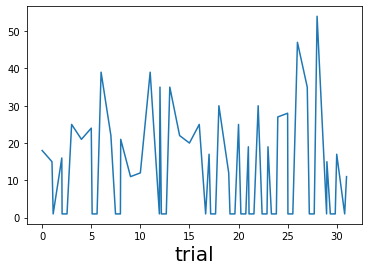

In [127]:
df.groupby('trial')[1].count().plot()

In [125]:
df.groupby(1)['trial']

1
0.0    659
1.0    158
Name: trial, dtype: int64

In [117]:
df

,v,lin_binned,theta_phase,theta_amp,trial,1,-1
Time (s),,,,,,,
6614.334433,12.566590,9.73,-0.001041,1228.620991,0.0,0.0,0.0
6614.367767,12.928865,9.97,0.024328,1239.536120,0.0,0.0,0.0
6614.401100,13.287502,10.22,0.041842,1249.197395,0.0,0.0,0.0
6614.434433,13.642229,10.47,-0.009726,1253.091548,0.0,0.0,0.0
6614.467800,13.992446,10.72,0.002446,1251.699921,0.0,0.0,0.0
...,...,...,...,...,...,...,...
8266.420200,16.813699,77.01,-0.000676,976.125827,31.0,0.0,0.0
8266.453533,16.736044,77.24,0.018225,981.065693,31.0,1.0,0.0
8266.486867,16.670274,77.48,-0.028617,986.878645,31.0,1.0,0.0


In [41]:
section_markers

array([  0,  33,  50,  84, 100])

In [37]:
pd.cut(sw_beh_df,section_markers)

,v,lin_binned,theta_phase,theta_amp,trial,1,-1
Time (s),,,,,,,
6596.563233,NaN,4,0.771996,647.350491,NaN,0,0
6596.596600,NaN,4,2.637343,529.478917,NaN,0,0
6596.629933,NaN,4,-1.667300,405.380783,NaN,0,0
6596.663267,NaN,4,0.544824,326.928684,NaN,0,0
6596.696600,NaN,4,2.833718,389.842228,NaN,0,0
...,...,...,...,...,...,...,...
8438.263767,NaN,98,0.700314,1112.252634,34.0,0,0
8438.297133,NaN,98,2.455421,938.987070,34.0,0,0
8438.330467,NaN,98,-2.040790,790.979421,34.0,0,0


In [23]:
np.histogram(all_sw_times_v_combined['time'],index)

(array([0, 0, 0, ..., 0, 0, 0]),
 array([6596.5299    , 6596.56326667, 6596.5966    , ..., 8438.33046667,
        8438.3638    , 8438.43046667]))

In [19]:
index

array([6596.5299    , 6596.56326667, 6596.5966    , ..., 8438.33046667,
       8438.3638    , 8438.43046667])

In [12]:
spk_beh_df[beh_vars]

,v,lin_binned,theta_phase,theta_amp,trial
Time (s),,,,,
6596.563233,NaN,4,0.771996,647.350491,NaN
6596.596600,NaN,4,2.637343,529.478917,NaN
6596.629933,NaN,4,-1.667300,405.380783,NaN
6596.663267,NaN,4,0.544824,326.928684,NaN
6596.696600,NaN,4,2.833718,389.842228,NaN
...,...,...,...,...,...
8438.263767,NaN,98,0.700314,1112.252634,34.0
8438.297133,NaN,98,2.455421,938.987070,34.0
8438.330467,NaN,98,-2.040790,790.979421,34.0


In [272]:
task_ind=0
ts=spk_beh_df.query('task_index==@task_ind').index
time_range=(ts[0],ts[-1])

In [281]:
time_range = time_range
count_in_time,edges=cpacas.count_diff_in_time(all_sw_times_v_combined,time_range,window_size=30.)

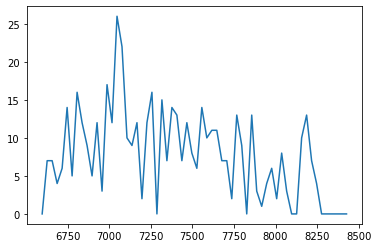

In [282]:
%matplotlib inline
plt.plot(edges[:-1],count_in_time)

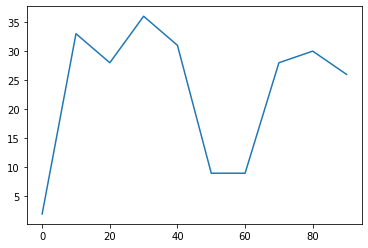

In [283]:
space_range = (0,99)
all_sw_times_v_combined_vthresh = all_sw_times_v_combined.query('v>10')
count_in_time,edges=cpacas.count_diff_in_time(all_sw_times_v_combined_vthresh,space_range,window_size=10.,key='field_pos')
plt.plot(edges[:-1],count_in_time)

In [421]:
pf_all_field_combined.rename({'com':'field_pos'},axis=1)

start end field_pos peak    fr_peak   fr_mean
         field_index                                              
0    31  0               2  13         7   10    7.06924  5.433991
         1              66  81        73   75   9.166158  6.626543
     32  1              43  48        45   45   5.351963  4.199355
     33  0              79  86        82   82   6.677062   5.30254
     34  0              48  54        50   51   3.398153   3.22187
...                    ...  ..       ...  ...        ...       ...
both 361 0               2  17         9   10   8.306651   5.29541
     363 0              11  30        18   16   4.887873  2.781876
     368 0               3  10         6    7   3.370542  2.879066
     374 0               2  16         9   10  12.799865  6.790906
     376 0               2   9         4    2   3.905575  2.900824

[574 rows x 6 columns]

In [422]:
reload(cpacas)
lims = (0,99)
window_size=5
key='field_pos'
onoff = 1
field_counter = pf_all_field_combined.rename({'com':'field_pos'},axis=1)
count_l,edges=cpacas.count_switch(all_sw_times_v_combined,lims,all_fields_times_v=field_counter,window_size=window_size,v_thresh=-100,key=key,onoff=onoff)

<AxesSubplot:xlabel='edges'>

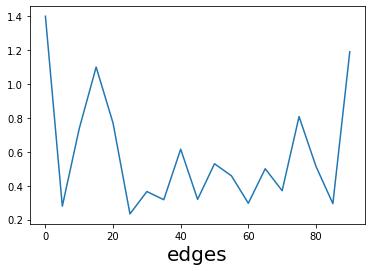

In [423]:
count_l.set_index('edges')['ratio'].plot()

<AxesSubplot:xlabel='edges'>

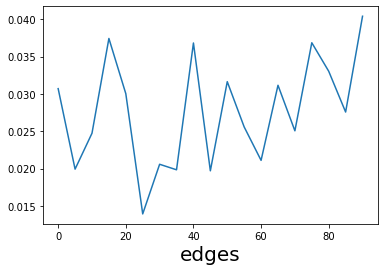

In [406]:
count_l.set_index('edges')['ratio'].plot()

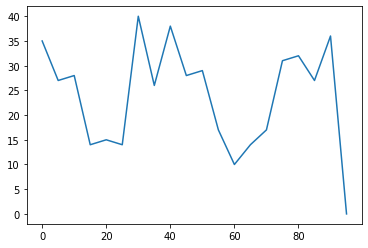

In [288]:
all_sw_times_v_combined_vthresh = all_sw_times_v_combined.query('v>=0')
count_in_time,edges=cpacas.count_diff_in_time(all_sw_times_v_combined_vthresh,(0,99),window_size=5.,key='field_pos')
plt.plot(edges[:-1],count_in_time)

In [373]:
all_fields_times_v['']

,trialtype,uid,field_index,time,v,trial_index
0,both,32,0,6613.550900,34.641256,0.0
1,both,35,0,6613.850967,37.103667,0.0
2,both,38,0,6613.617567,35.768825,0.0
3,both,54,0,6613.850967,37.103667,0.0
4,both,55,1,6613.217467,19.896570,0.0
...,...,...,...,...,...,...
333,0,368,1,8265.536633,21.419373,31.0
334,0,369,0,8265.236550,18.914466,31.0
335,0,370,0,8257.101150,4.000607,31.0
336,0,371,0,8265.319900,19.746891,31.0


<AxesSubplot:xlabel='Time (s)'>

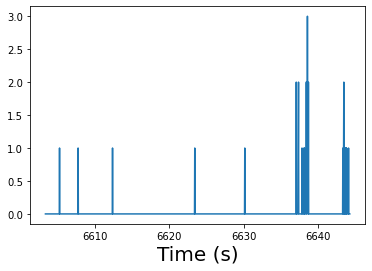

In [298]:
spk_beh_df.query('trial==0')[170].plot()

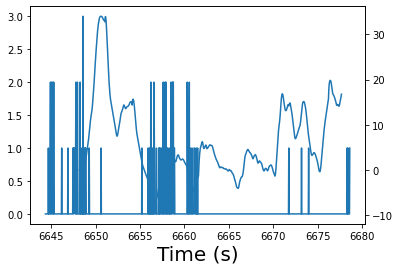

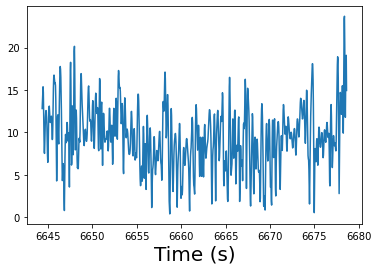

In [369]:
sub = spk_beh_df.query('(trial==1)')
ax=sub[170].plot()
# ax.set_xlim([6645,6650])
ax2=ax.twinx()
ax2=sub['v'].plot(ax=ax2)
plt.figure()
ax=(sub['theta_amp']/100).plot()
# ax.set_xlim([6645,6650])
# ax2=ax.twinx()
# ax2=(sub['theta_phase']).plot(ax=ax2)


In [317]:
filtered['timestamps']

(31878000,)

In [314]:
filtered['amp']

array([419.78713409, 296.76773659, 305.59274116, ..., 244.52745051,
       262.13924675, 410.71500933])

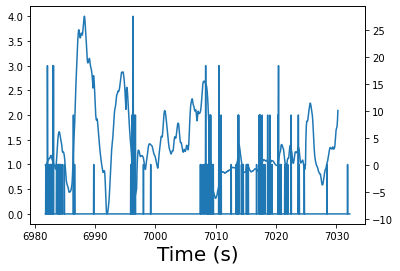

In [309]:
tr=8
ax=spk_beh_df.query('trial==@tr')[170].plot()
ax2=ax.twinx()
ax2=spk_beh_df.query('trial==@tr')['v'].plot(ax=ax2)

In [293]:
all_sw_times_v_combined.loc[all_sw_times_v_combined['v']<=1]

,trialtype,uid,field_index,time,v,field_pos,trial_index,switch
2,both,170,0,6648.293033,0.055908,1.0,1,1.0
3,both,246,0,6648.293033,0.055908,1.0,1,1.0
6,both,368,0,6648.293033,0.055908,1.0,1,1.0
2,both,213,0,6715.243333,0.007748,1.0,3,1.0
6,1,154,0,6717.994033,0.489307,5.0,3,-1.0
7,0,140,0,6767.689983,0.319029,2.0,4,1.0
8,0,161,0,6767.689983,0.319029,2.0,4,1.0
4,both,267,0,6808.817067,0.025180,1.0,5,1.0
8,0,140,0,6858.796433,0.144886,2.0,6,-1.0
11,0,165,0,6889.020767,0.226218,50.0,6,-1.0


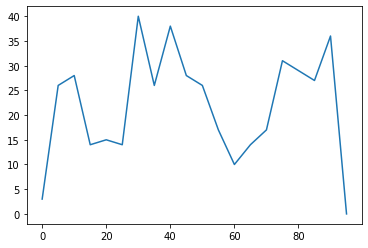

In [289]:
all_sw_times_v_combined_vthresh = all_sw_times_v_combined.query('v>=1')
count_in_time,edges=cpacas.count_diff_in_time(all_sw_times_v_combined_vthresh,(0,99),window_size=5.,key='field_pos')
plt.plot(edges[:-1],count_in_time)

In [56]:
all_sw_times_v_combined

,trialtype,uid,field_index,time,v,field_pos,trial_index,switch
0,both,29,1,7893.902900,36.778932,21.0,1,1.0
1,both,140,0,7893.386117,7.336045,9.0,1,1.0
2,both,455,0,7893.252750,1.939159,7.0,1,1.0
0,both,168,0,7918.842533,36.627722,23.0,2,-1.0
1,both,386,1,7918.492467,29.929168,18.0,2,1.0
...,...,...,...,...,...,...,...,...
13,1,311,1,9989.965667,21.281060,63.0,69,-1.0
14,1,378,1,9998.351117,11.046759,89.0,69,1.0
15,1,424,0,9988.131867,2.869145,51.0,69,1.0
16,1,430,1,9998.151067,7.238519,87.0,69,1.0


In [12]:
db

data_dir_full  \
animal_name                                                        
e13_16f1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            4  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
...                                                          ...   
IZ32        0  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
IZ33        0  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            1  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            2  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            3  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   

                              sess_name animal_name.1        date  \
animal_name                                                         
e13_16f1    0           e13_16f1_210302      e13_16f1  2021-03-02   
            1           e13_16f1_210312      e13_16f1  2021-03-12   
            2           e13_16f1_210314      e13_16f1  2021-03-14   
            3           e13_16f1_210315      e13_16f1  2021-03-15   
            4           e13_16f1_210317      e13_16f1  2021-03-17   
...                                 ...           ...         ...   
IZ32        0  IZ32_1008um_210303_sess7          IZ32  2021-03-03   
IZ33        0   IZ33_580um_210312_sess8          IZ33  2021-03-12   
            1   IZ33_580um_210315_sess9          IZ33  2021-03-15   
            2  IZ33_580um_210317_sess10          IZ33  2021-03-17   
            3  IZ33_580um_210319_sess11          IZ33  2021-03-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_16f1    0                    alternation     0.571429       21   
            1                    alternation     0.950000       20   
            2                    alternation     0.875000       24   
            3                    alternation     0.789474       19   
            4                    alternation     0.875000       24   
...                                      ...          ...      ...   
IZ32        0  ['alternation' 'alternation']     0.833333      102   
IZ33        0  ['alternation' 'alternation']     0.841463       82   
            1  ['alternation' 'alternation']     0.829268       82   
            2  ['alternation' 'alternation']     0.804878       82   
            3  ['alternation' 'alternation']     0.795181       83   

               ngoodtrials  n_neurons  n_pyr_putative    owner     data_root  
animal_name                                                                   
e13_16f1    0           21        135             114    roman    roman_data  
            1           20        124             105    roman    roman_data  
            2           24        121             102    roman    roman_data  
            3           19        114              92    roman    roman_data  
            4           24        130             112    roman    roman_data  
...                    ...        ...             ...      ...           ...  
IZ32        0          102         89              76  ipshita  ipshita_data  
IZ33        0           82        180             120  ipshita  ipshita_data  
            1           82        143              77  ipshita  ipshita_data  
            2           82        169             106  ipshita  ipshita_data  
            3           83        152              95  ipshita  ipshita_data  

[72 rows x 12 columns]

In [14]:
db

data_dir_full  \
animal_name                                                        
e13_16f1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
            4  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
...                                                          ...   
IZ32        0  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
IZ33        0  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            1  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            2  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            3  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   

                              sess_name animal_name.1        date  \
animal_name                                                         
e13_16f1    0           e13_16f1_210302      e13_16f1  2021-03-02   
            1           e13_16f1_210312      e13_16f1  2021-03-12   
            2           e13_16f1_210314      e13_16f1  2021-03-14   
            3           e13_16f1_210315      e13_16f1  2021-03-15   
            4           e13_16f1_210317      e13_16f1  2021-03-17   
...                                 ...           ...         ...   
IZ32        0  IZ32_1008um_210303_sess7          IZ32  2021-03-03   
IZ33        0   IZ33_580um_210312_sess8          IZ33  2021-03-12   
            1   IZ33_580um_210315_sess9          IZ33  2021-03-15   
            2  IZ33_580um_210317_sess10          IZ33  2021-03-17   
            3  IZ33_580um_210319_sess11          IZ33  2021-03-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_16f1    0                    alternation     0.571429       21   
            1                    alternation     0.950000       20   
            2                    alternation     0.875000       24   
            3                    alternation     0.789474       19   
            4                    alternation     0.875000       24   
...                                      ...          ...      ...   
IZ32        0  ['alternation' 'alternation']     0.833333      102   
IZ33        0  ['alternation' 'alternation']     0.841463       82   
            1  ['alternation' 'alternation']     0.829268       82   
            2  ['alternation' 'alternation']     0.804878       82   
            3  ['alternation' 'alternation']     0.795181       83   

               ngoodtrials  n_neurons  n_pyr_putative    owner     data_root  
animal_name                                                                   
e13_16f1    0           21        135             114    roman    roman_data  
            1           20        124             105    roman    roman_data  
            2           24        121             102    roman    roman_data  
            3           19        114              92    roman    roman_data  
            4           24        130             112    roman    roman_data  
...                    ...        ...             ...      ...           ...  
IZ32        0          102         89              76  ipshita  ipshita_data  
IZ33        0           82        180             120  ipshita  ipshita_data  
            1           82        143              77  ipshita  ipshita_data  
            2           82        169             106  ipshita  ipshita_data  
            3           83        152              95  ipshita  ipshita_data  

[72 rows x 12 columns]

 25%|██▌       | 1/4 [00:00<00:01,  1.55it/s]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211213/py_data/switch_analysis/switch_res_window.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211212/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/h

 50%|█████     | 2/4 [00:10<00:12,  6.10s/it]

e16_3m2_211212 failed, x and y arrays must have at least 2 entries


 75%|███████▌  | 3/4 [00:12<00:04,  4.35s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211211/py_data/switch_analysis/switch_res_window.p exists; loading---


100%|██████████| 4/4 [00:15<00:00,  3.77s/it]

/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m2/e16_3m2_211210/py_data/switch_analysis/switch_res_window.p exists; loading---


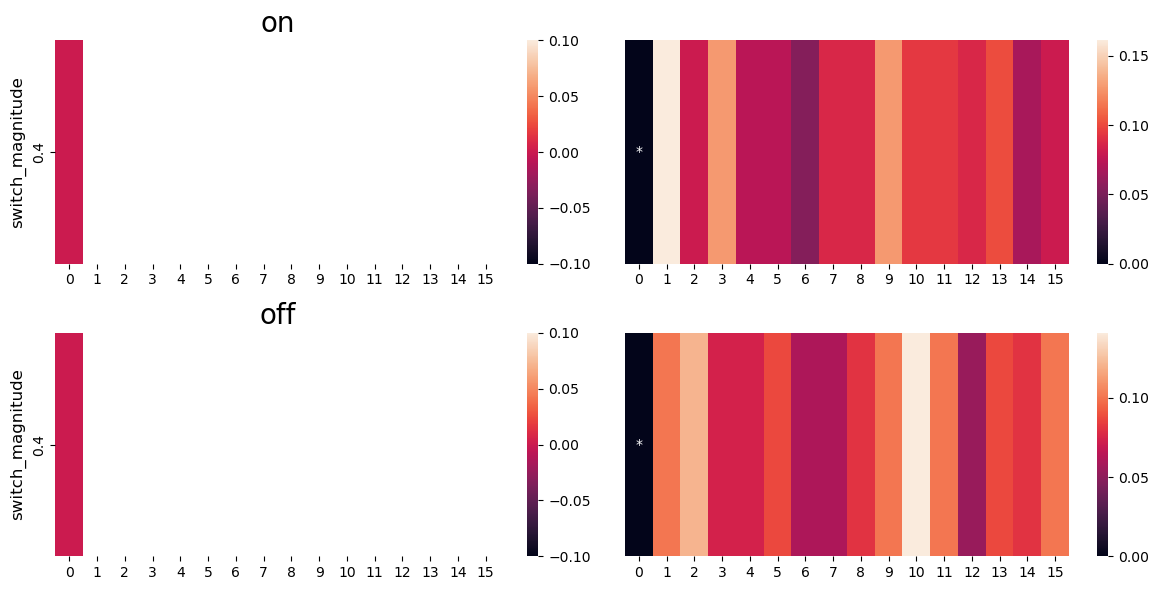

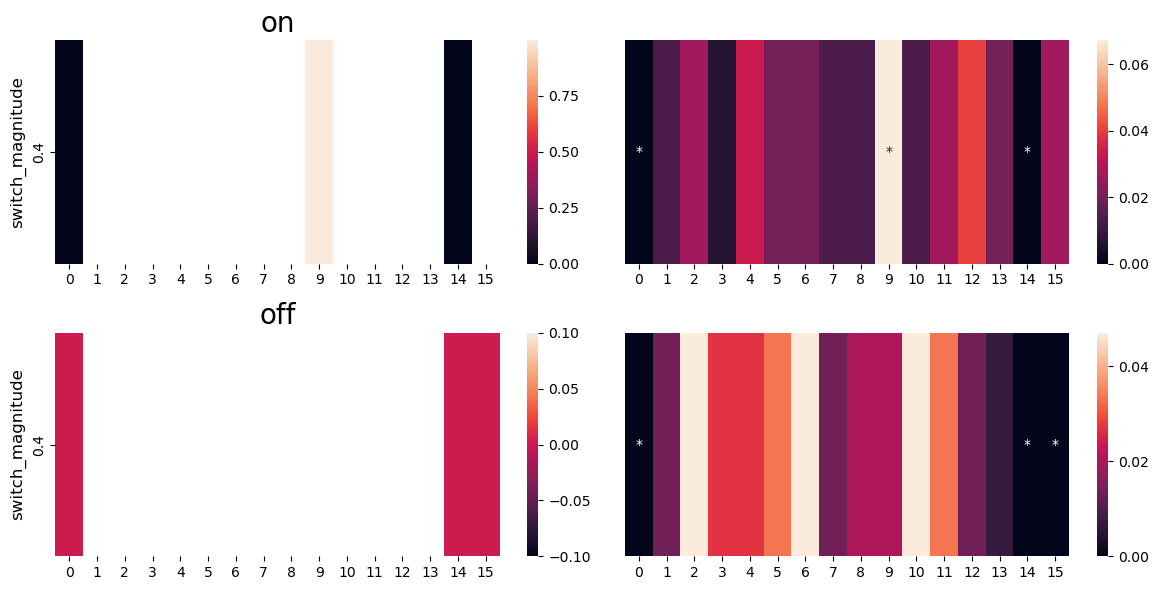

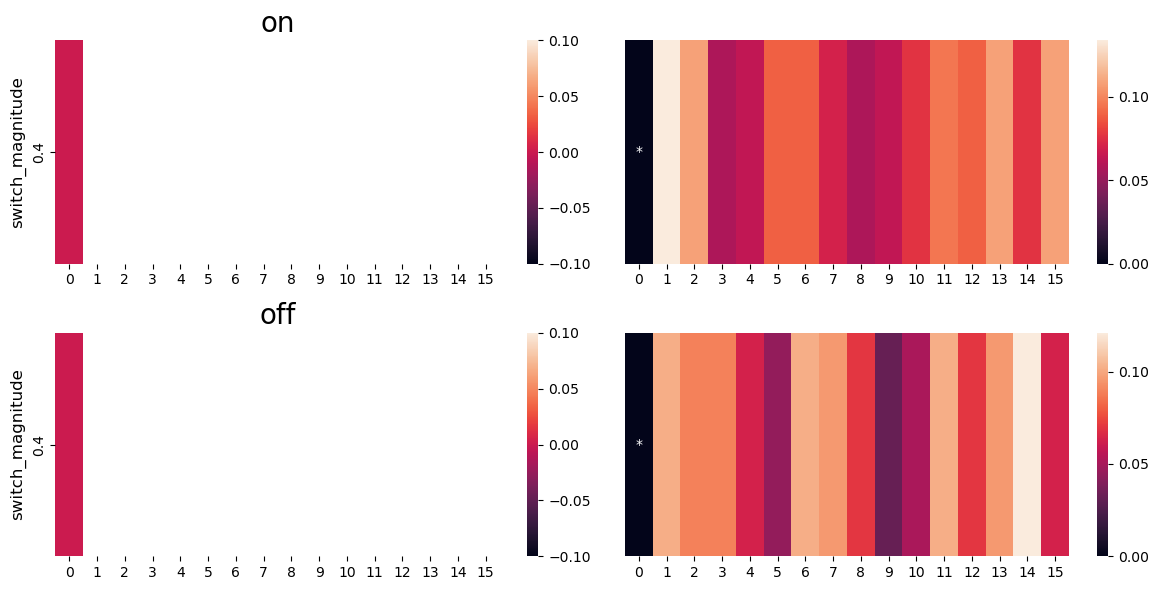

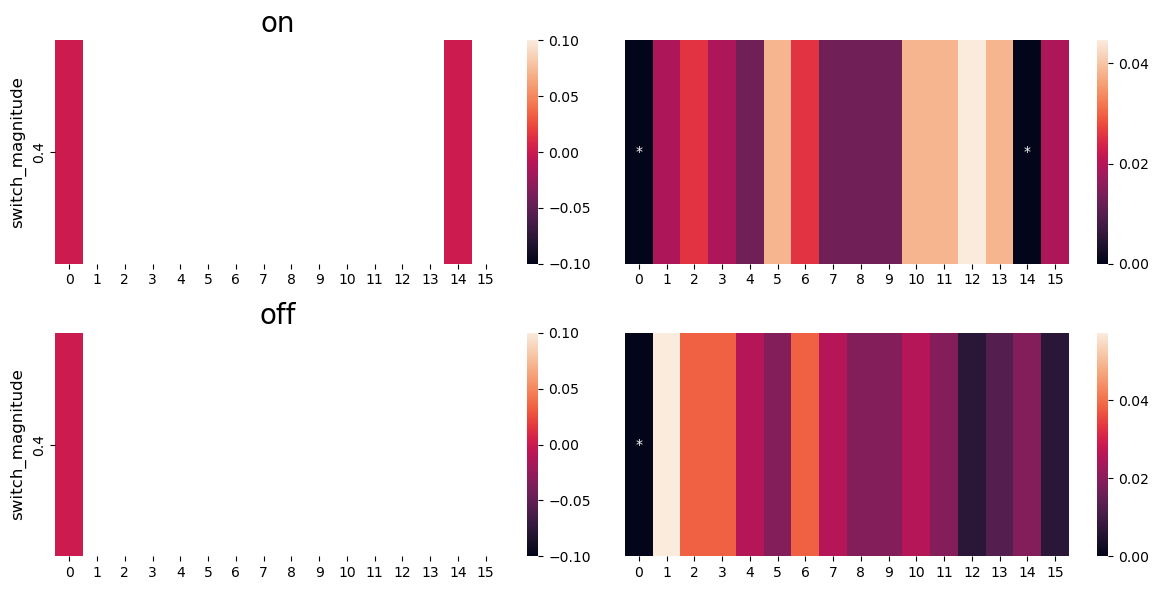

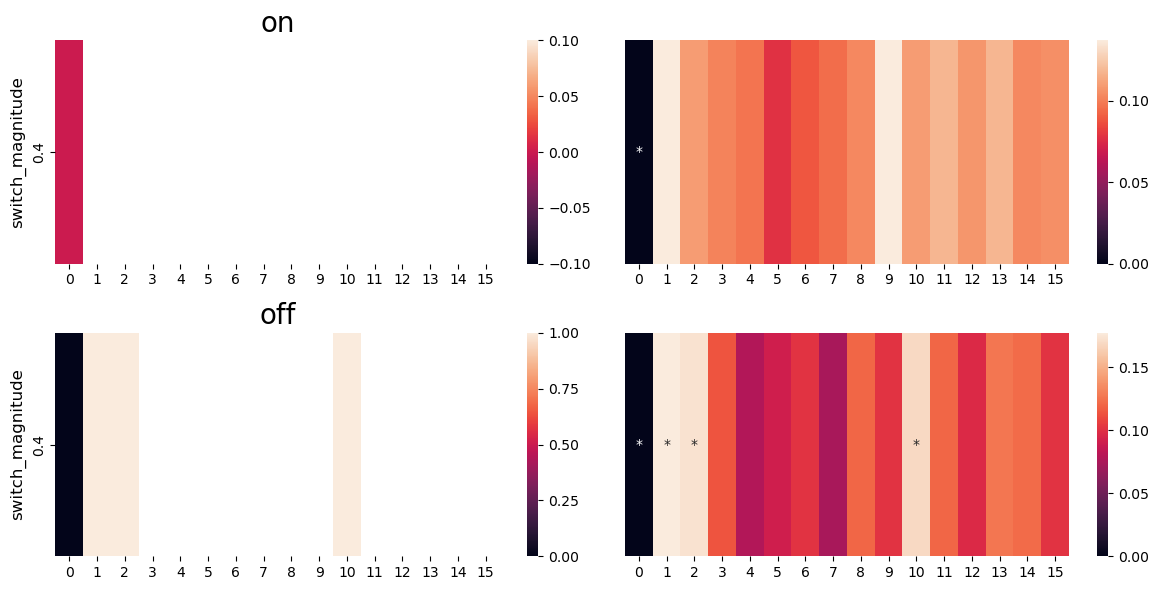

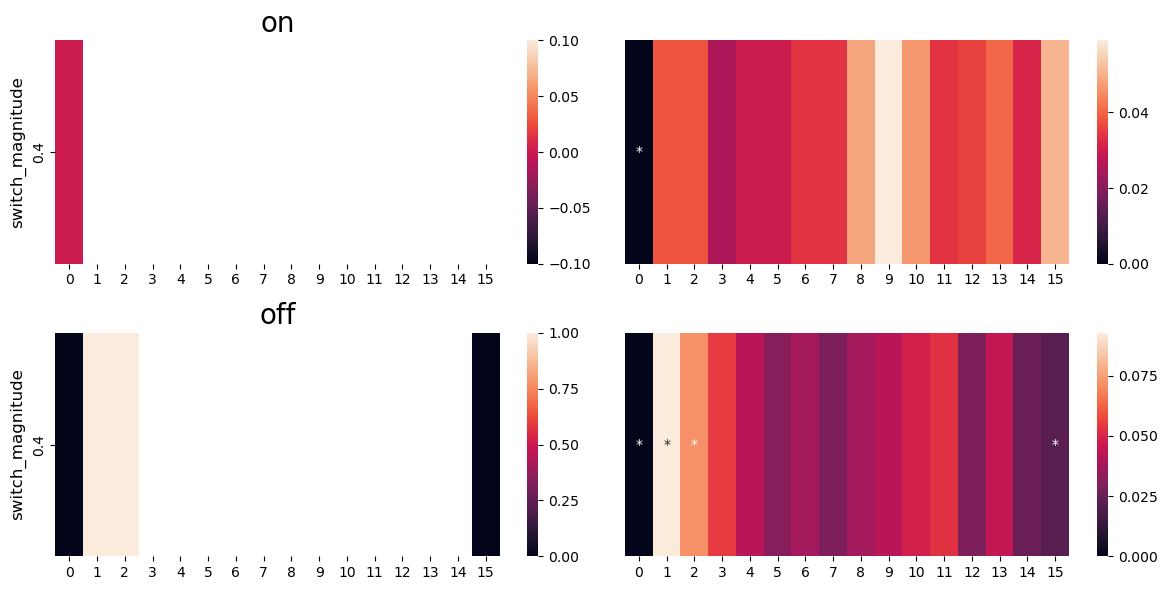

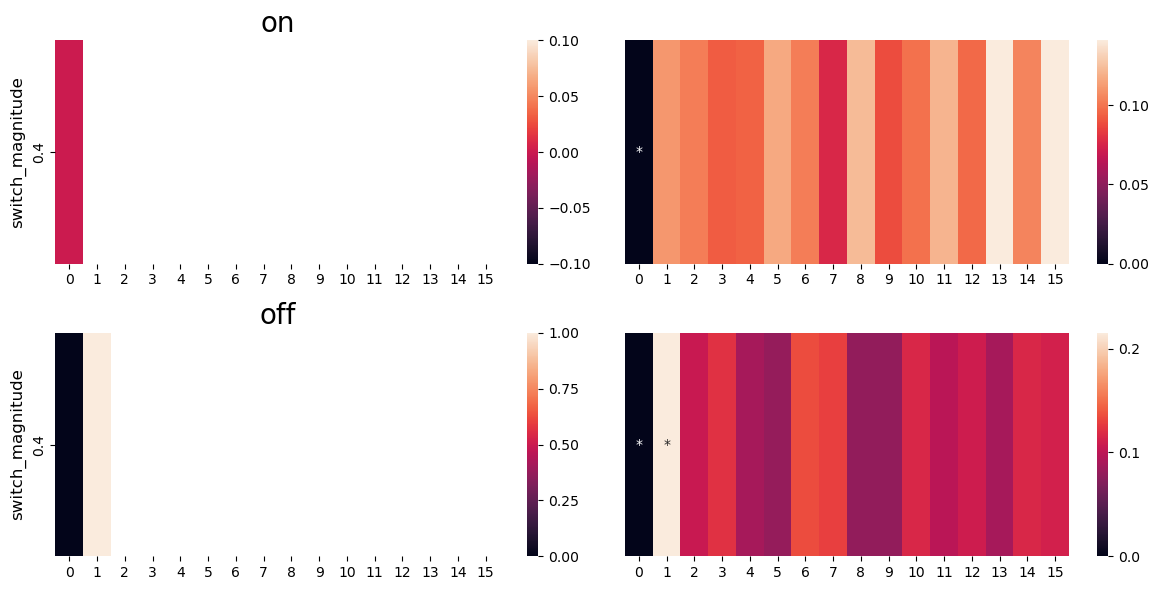

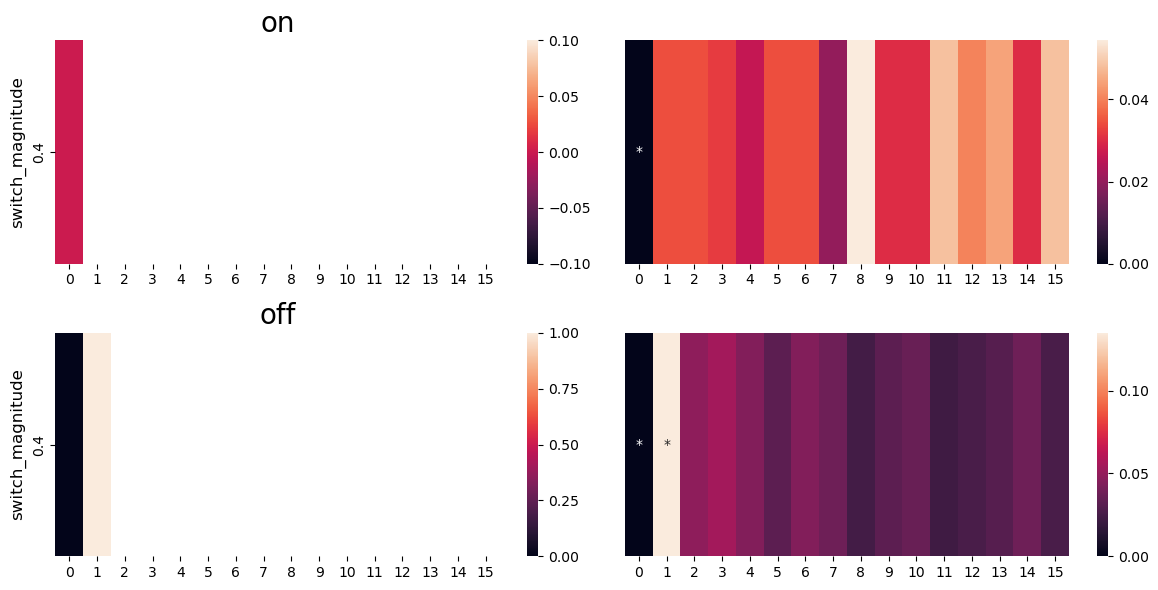

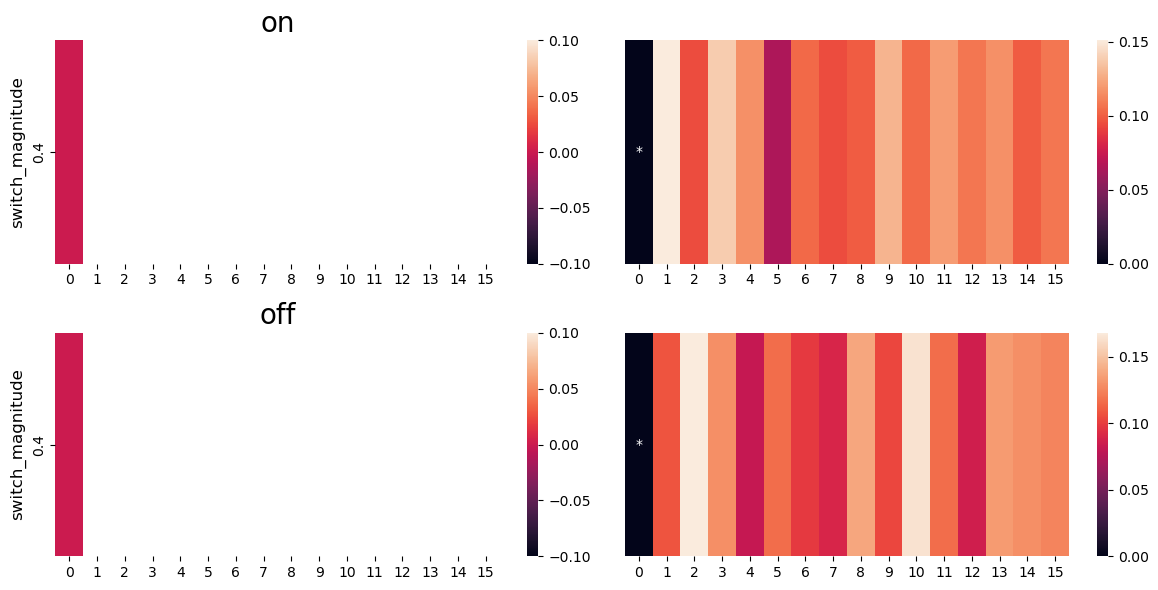

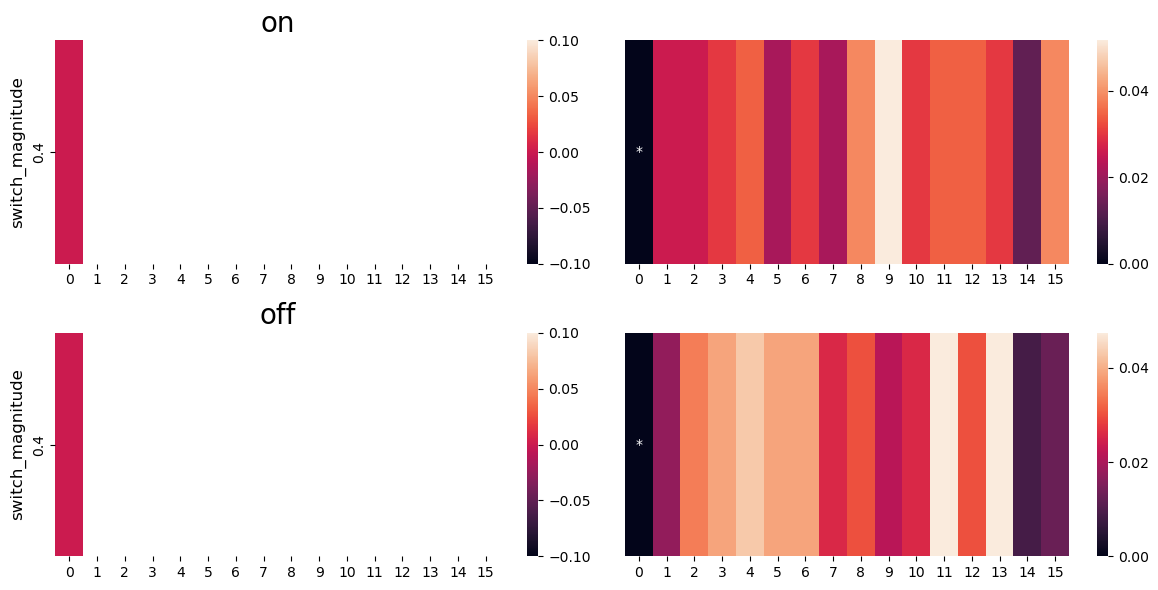

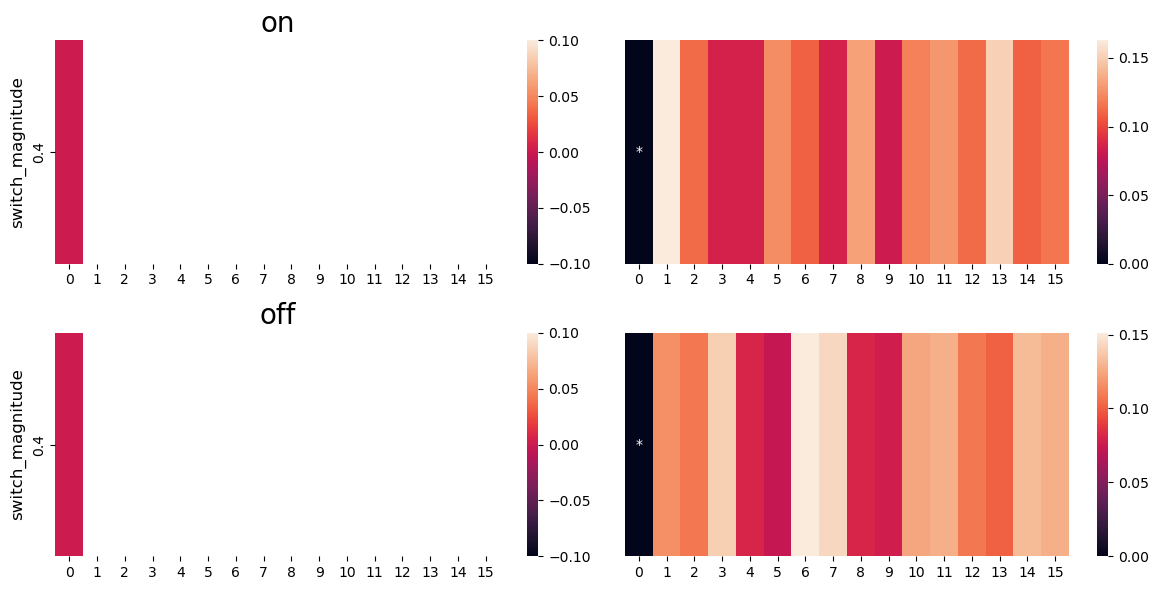

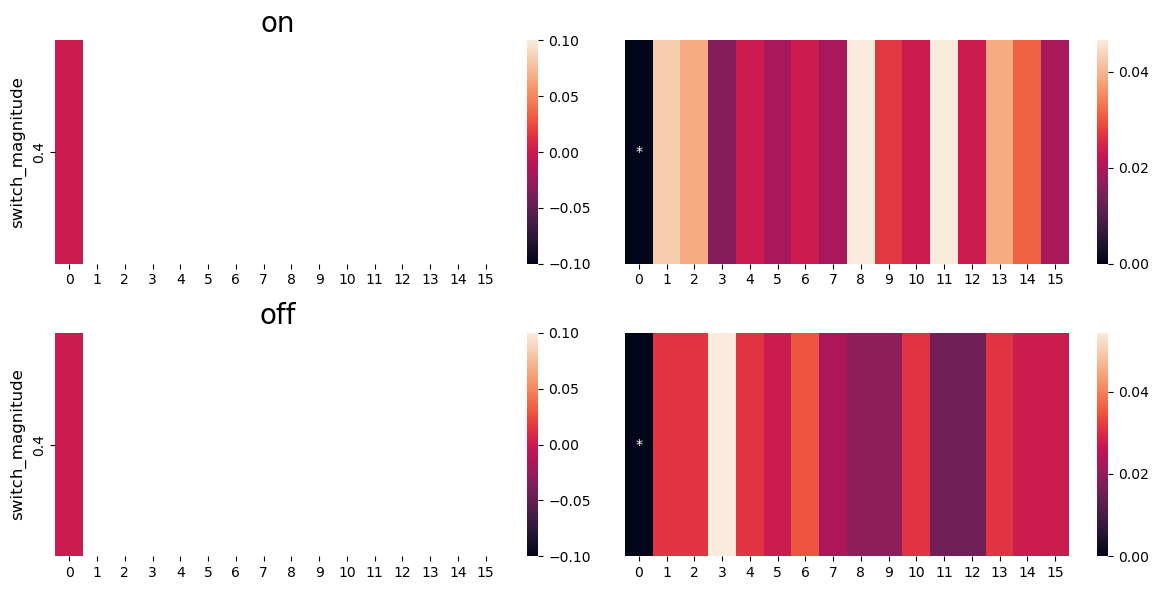

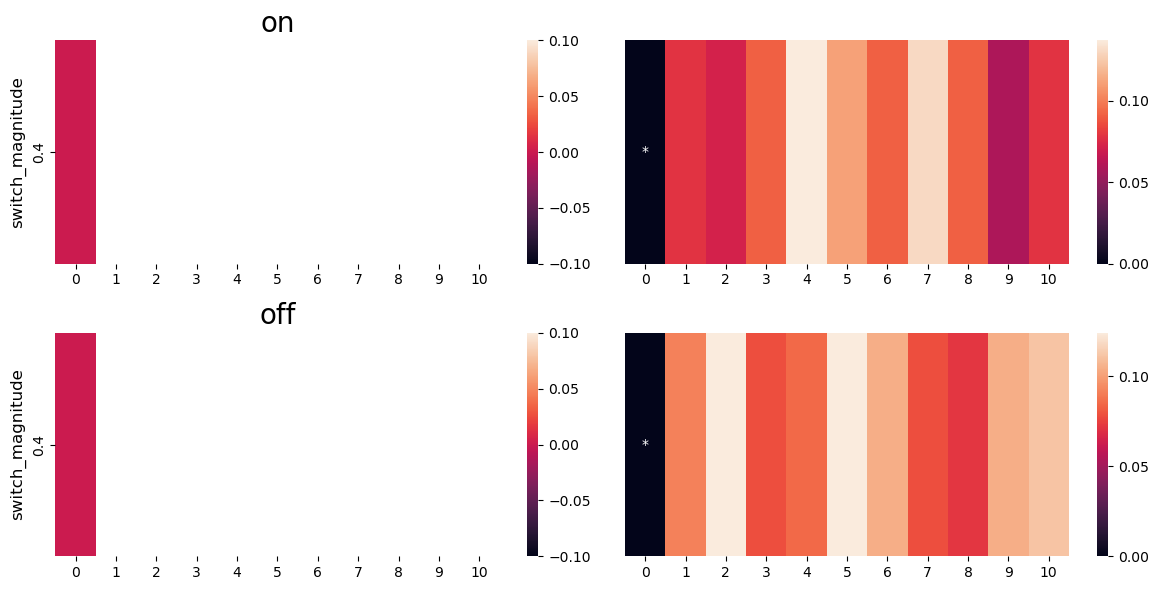

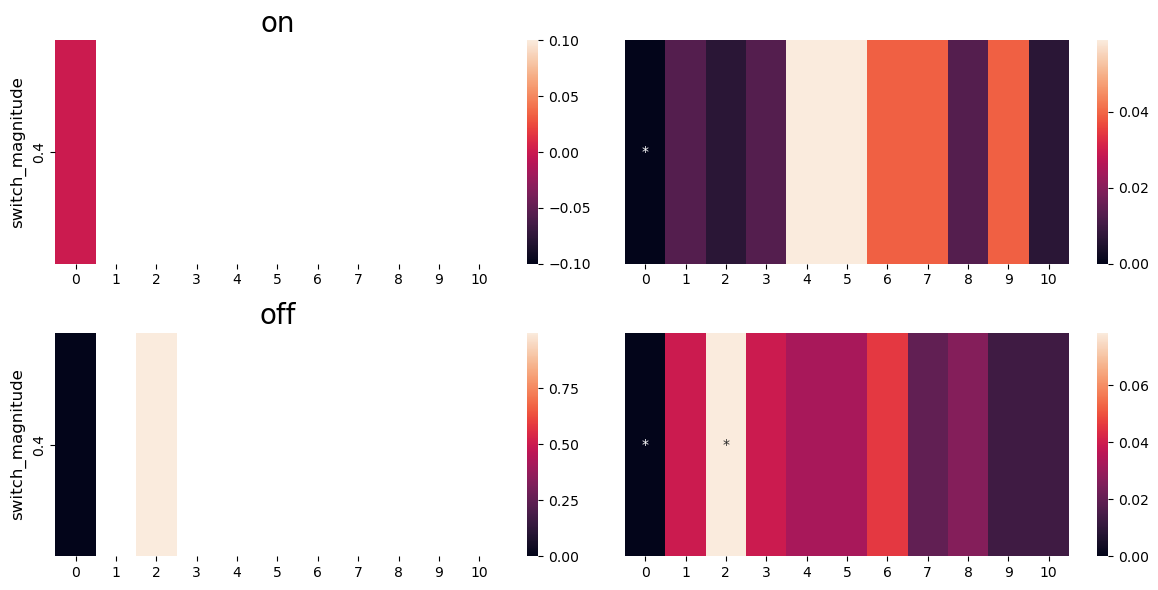

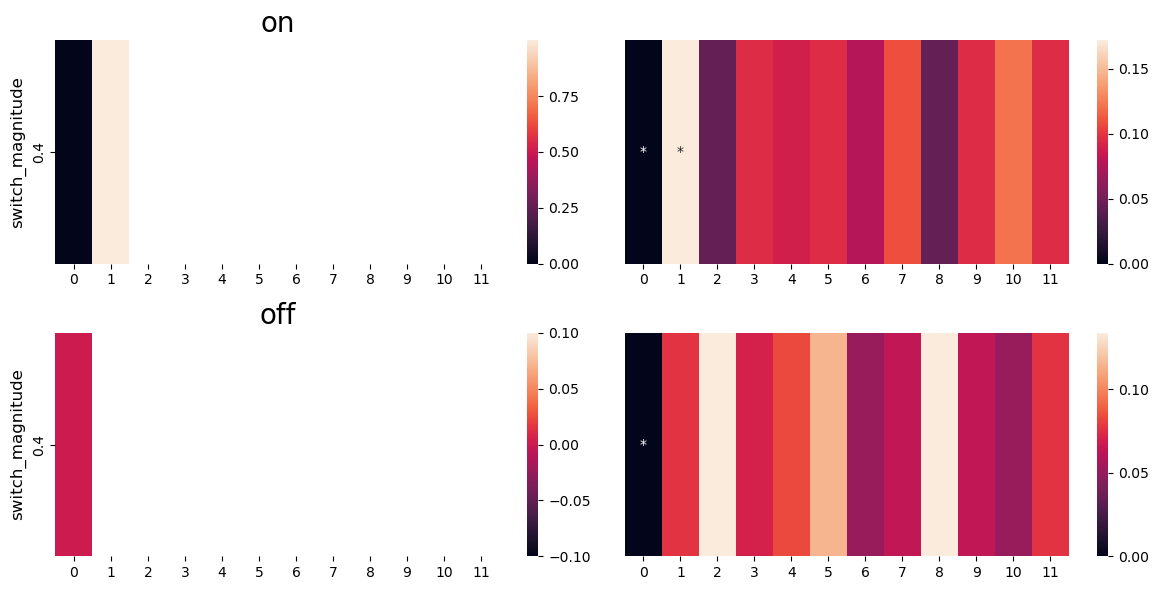

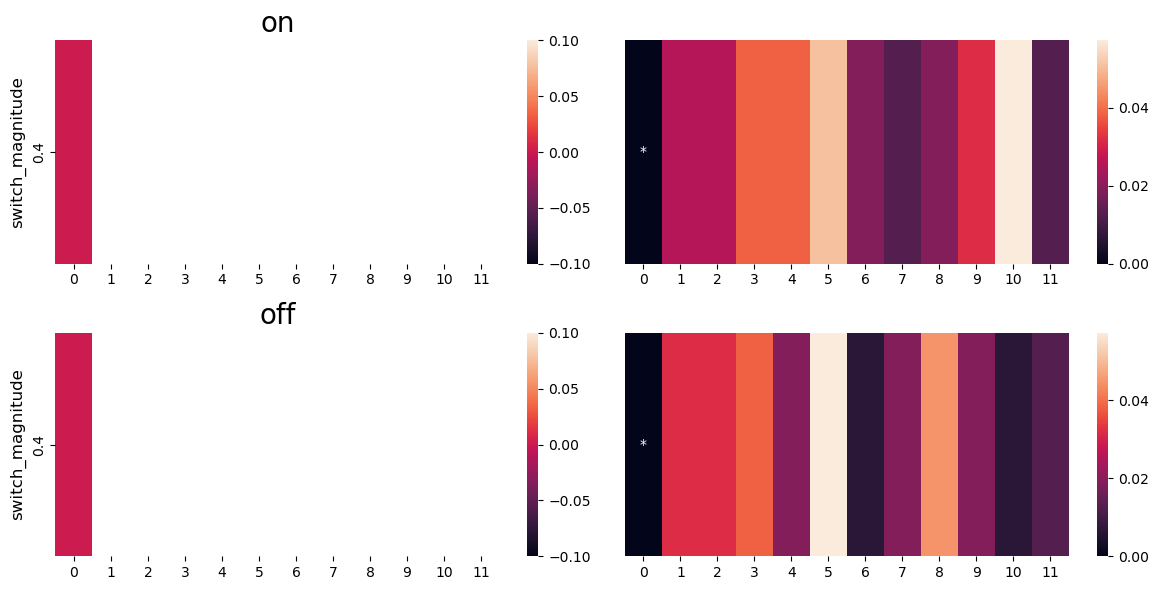

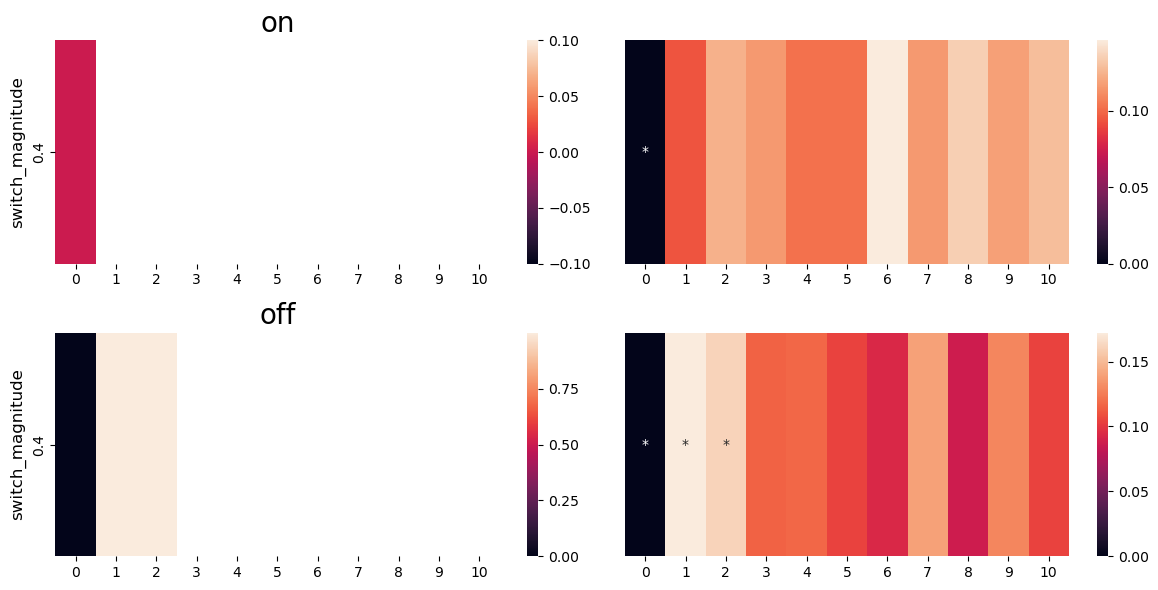

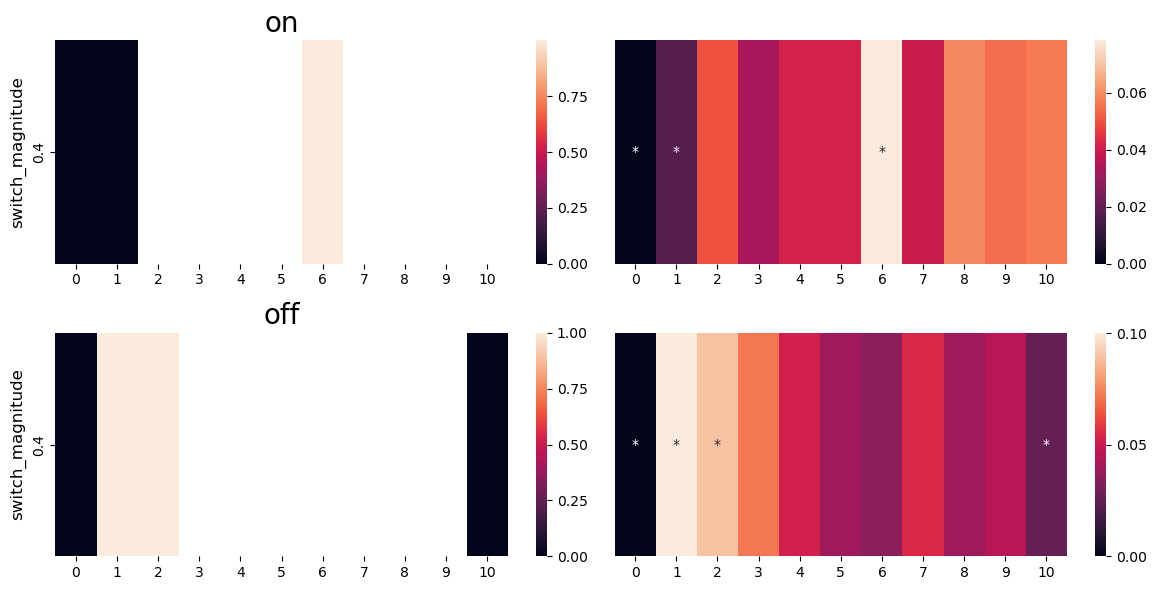

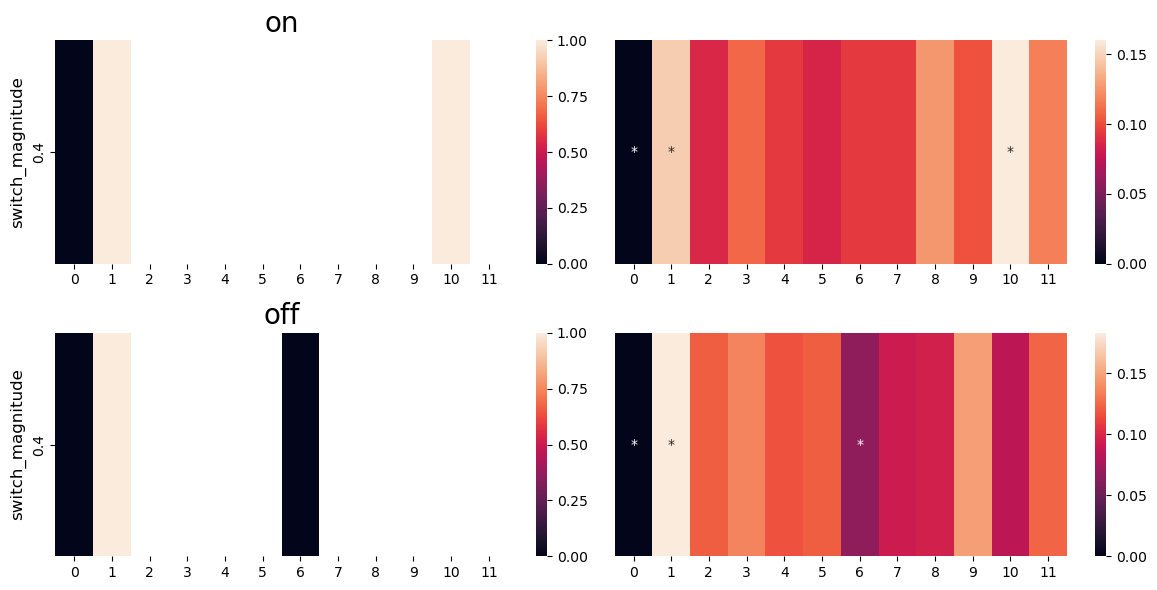

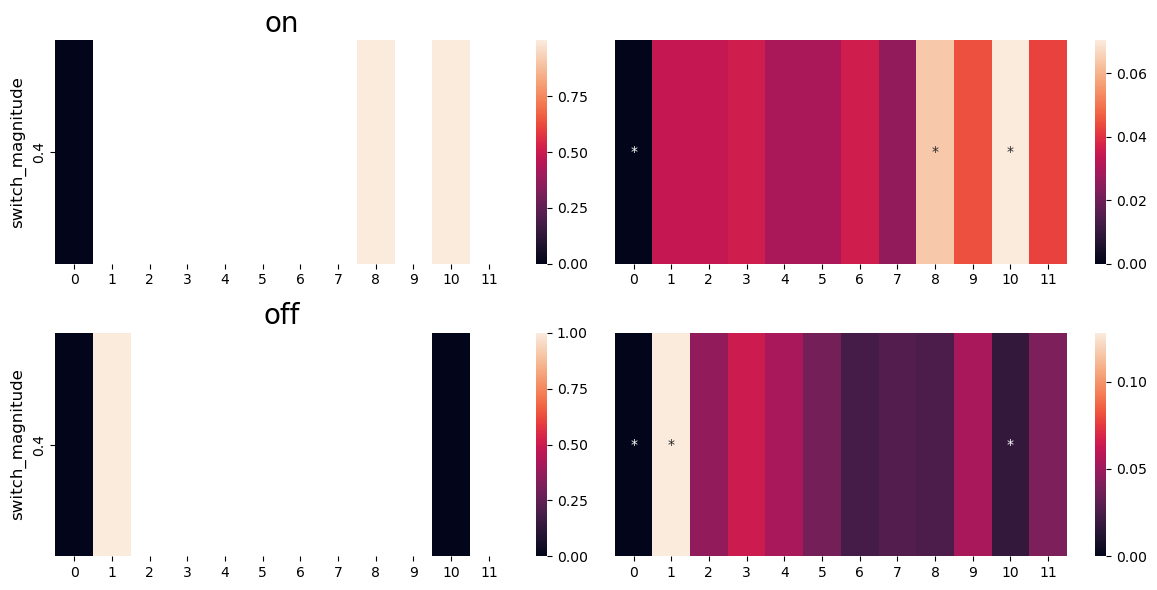

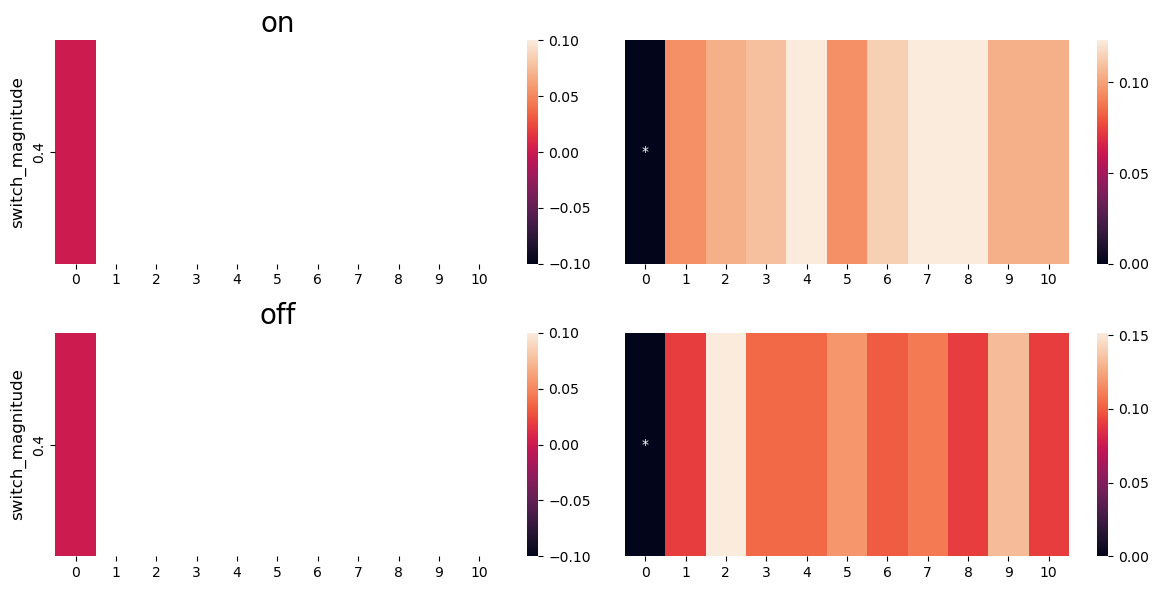

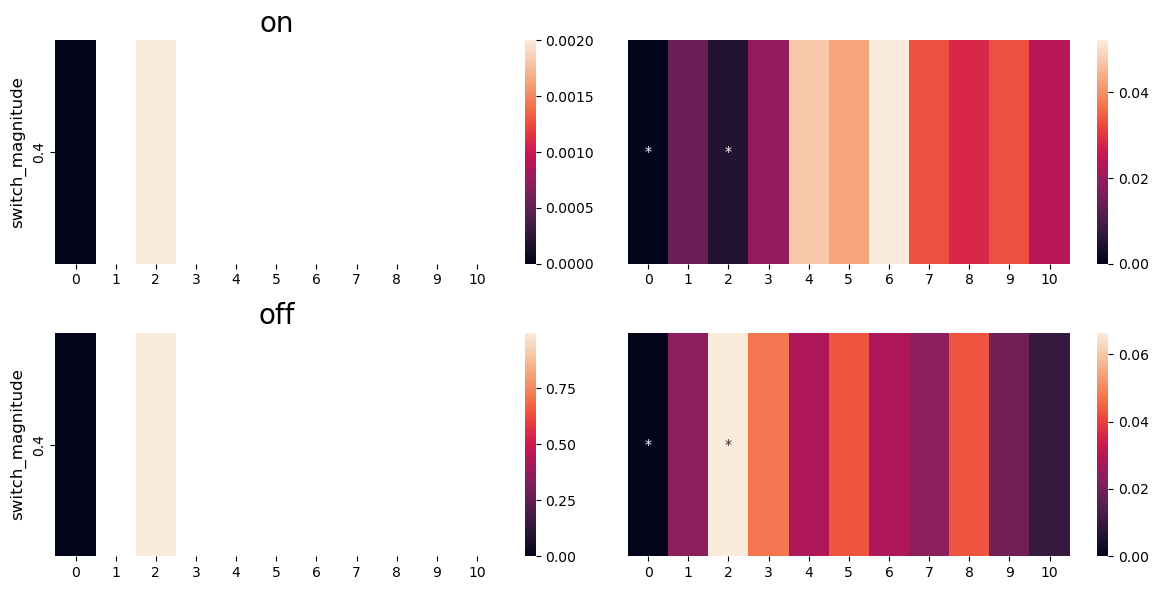

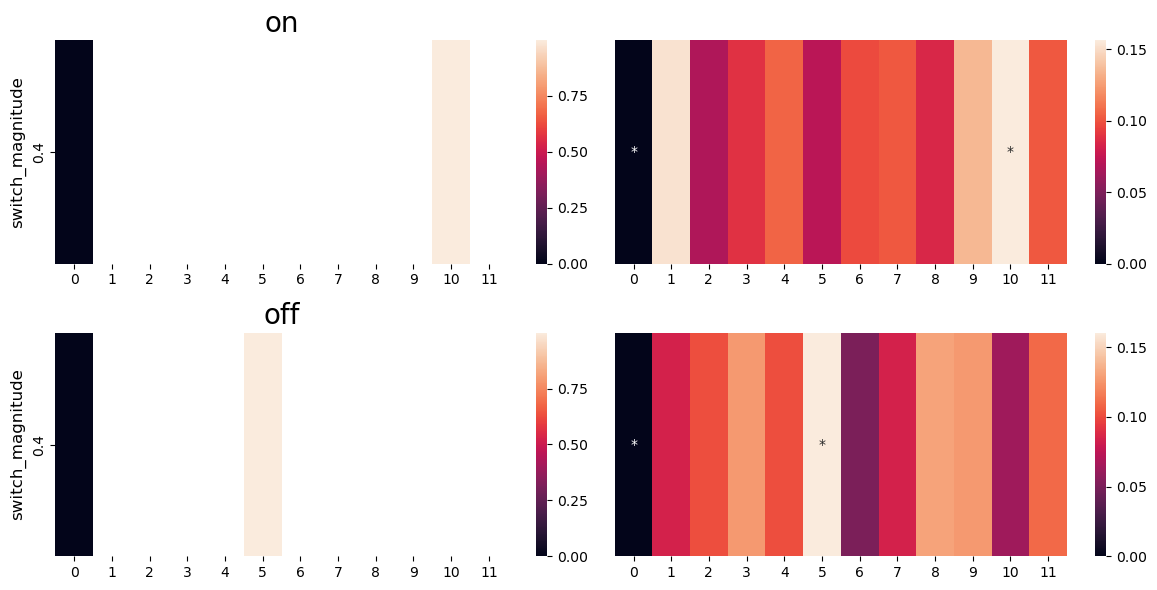

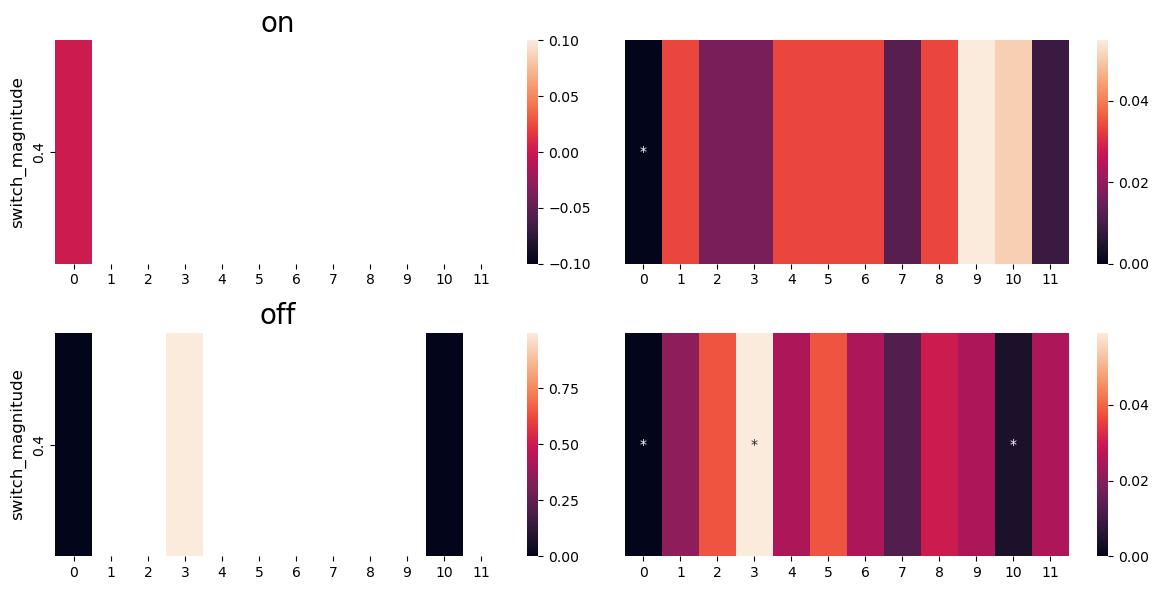

In [204]:
import tqdm
ani = 'e16_3m2'#'e15_13f1'#'e13_26m1'
subdb = db.loc[ani].sort_values('n_pyr_putative',ascending=False)
edges = np.concatenate([np.linspace(0,0.9,9),np.arange(1,400,10)])

success_sess = []
fail_sess = []

task_ind = 0
query=(task_ind,slice(None),0.3,'switch_magnitude',0.4)

changes_df_both_d = {}
all_sw_times_v_combined_d = {}
nfields_d = {}
all_fields_both_d = {}
pf_loc_combined_d = {}
pf_all_field_combined_d = {}

for i in tqdm.tqdm(range(subdb.shape[0])):
    row = subdb.iloc[i]
    sess = row['sess_name'] 
    data_dir_full = row['data_dir_full']
    try:
        switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)
        pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )
        
        all_fields_both =pd.concat(pf_res['avg']['all_fields'],axis=0)
        
        changes_df_both = switch_res['avg']['changes_df'].loc[query]
        changes_df_both_d[sess] = changes_df_both
        test_res = cpacas.sweep_test_coswitch_wrapper(data_dir_full,
                                    pf_res_save_fn='place_field_avg_and_trial_vthresh.p',
                                    pf_shuffle_fn = 'fr_map_null_trialtype_vthresh.p',
                                    speed_key='v',
                                    bin_size=2.2,
                                    switch_res_query=(slice(None),0.3,'switch_magnitude',0.4),
                                    nrepeats_sw = 1,
                                    edges = edges,
                                    force_reload=False,
                                    dosave=False,
                                    task_ind = 0,
                                    prep_force_reload=False,
                                    )
        all_sw_times_v_combined_d[sess]=test_res['all_sw_times_v_combined']
        pf_loc_combined_d[sess] = test_res['pf_loc_combined']
        nfields = test_res['pf_loc_combined'].shape[0]
        nfields_d[sess] = nfields
        all_fields_both_d[sess] = all_fields_both
        pf_all_field_combined_d[sess] = test_res['pf_all_field_combined']
        
        success_sess.append(sess)
    except Exception as e:
        fail_sess.append((sess,e))
        print(f'{sess} failed, {e}')


In [205]:
changes_df_both_d = pd.concat(changes_df_both_d,axis=0)

switching_count = (changes_df_both_d==1).sum(axis=0)
base = (changes_df_both_d.notna()).sum(axis=0)

<IPython.core.display.Javascript object>


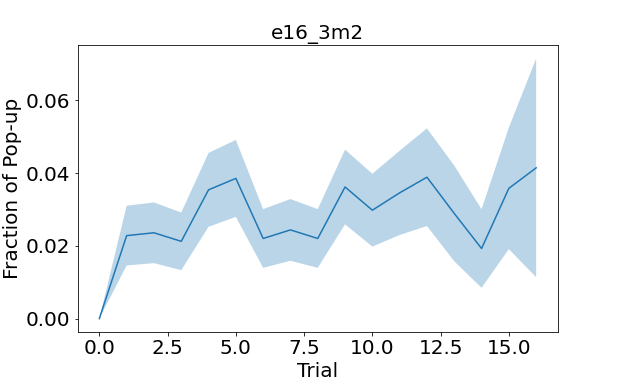

Text(0.5, 0, 'Trial')

In [211]:
plt.rcParams.update({'font.size':12})

%matplotlib notebook
p = (switching_count / base).T
se = np.sqrt((p * (1-p)) / base)
err = se * 1.96
p_high, p_low = p + err, p - err
fig,ax=plt.subplots(figsize=(8,5))
ax.fill_between(p.index,p_low,p_high,alpha=0.3)
ax.plot(p.index,p)
ax.set_title(ani)
ax.set_ylabel('Fraction of Pop-up')
ax.set_xlabel('Trial')




In [207]:
all_fields_both_d_df = pd.concat(all_fields_both_d,axis=0)

all_sw_times_v_combined_d_df = pd.concat(all_sw_times_v_combined_d,axis=0)

all_sw_times_v_combined_d_df_on = all_sw_times_v_combined_d_df.query('switch==1')

all_sw_times_v_combined_d_df_on_nodup =all_sw_times_v_combined_d_df_on.groupby(level=0).apply(lambda x:x.drop_duplicates(subset=['trialtype','uid','field_index']))



In [208]:
edges = [0,6.8,20,33.6,42,50.5,67,84,100]
# edges = np.linspace(1,93,20)
baseline_count,edges=np.histogram(all_fields_both_d_df['peak'],bins = edges)

count_df = all_sw_times_v_combined_d_df_on#all_sw_times_v_combined_d_df_on_nodup
sw_count_per_pos,edges=np.histogram(count_df['field_pos'],bins=edges)




frac_per_pos = sw_count_per_pos / baseline_count

In [209]:
section_dict={'home':[0,15],'central':[15,74],'T':[74,111],'return side':[111,185],'return central':[185,222]}
bounds = np.array([0,15,74,111,185,222])
bounds = bounds / 2.2
minor_ticks = (bounds[:-1] + bounds[1:])/2
labels = section_dict.keys()
    

Text(0, 0.5, 'density')

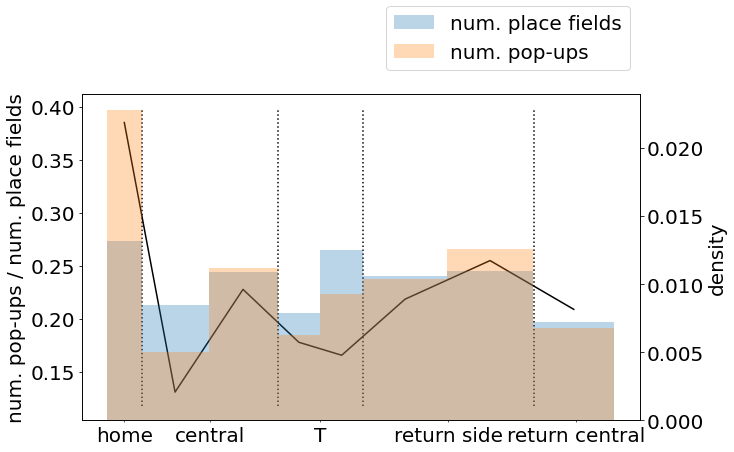

In [210]:
%matplotlib inline
plt.rcParams.update({'font.size':20})
fig,ax=plt.subplots(figsize=(10,6))
ax.set_xticks([])
ax.set_xticklabels('')

edges_center = (edges[:-1]+edges[1:])/2
ax.plot(edges_center,frac_per_pos,color='k')
ax.set_ylabel('num. pop-ups / num. place fields')



ylims=ax.get_ylim()
for xx in bounds[1:-1]:
    ax.vlines(xx,ylims[0],ylims[1],color='k',linestyle=':')
ax.set_xticks(minor_ticks,minor=True)
ax.set_xticklabels(labels,minor=True,rotation=0)


ax2 = ax.twinx()

ax2.hist(all_fields_both_d_df['peak'],bins = edges,density=True,alpha=0.3,label='num. place fields')
ax2.hist(count_df['field_pos'],bins = edges,density=True,alpha=0.3,label='num. pop-ups')
ax2.legend(bbox_to_anchor=[1,1.3])

ax2.set_ylabel('density')



In [131]:
def gen_shuffle_ratio(count,base,nrepeats=100):
    N = len(count)
    shift_l=np.random.randint(N,size=nrepeats)
    frac_null_l = []
    for i in shift_l:
        frac = np.roll(count,i) / baseline_count
        frac_null_l.append(frac)
    frac_null_l = np.array(frac_null_l)
    return frac_null_l
    

In [193]:
frac_null_l = gen_shuffle_ratio(sw_count_per_pos,baseline_count,nrepeats=1000)

In [194]:
np.quantile(frac_null_l,0.975,axis=0)

array([0.64736842, 0.55405405, 0.42560554, 0.67582418, 0.492     ,
       0.43462898, 0.39297125, 0.46768061])

In [195]:
np.quantile(frac_null_l,0.025,axis=0)

array([0.37368421, 0.31981982, 0.24567474, 0.39010989, 0.284     ,
       0.25088339, 0.22683706, 0.26996198])

In [135]:
frac_null_l.shape

(100, 19)

<AxesSubplot:>

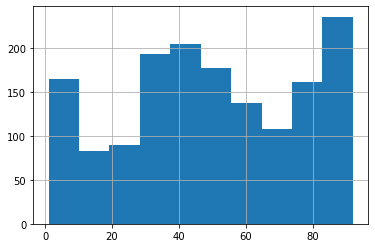

In [70]:
%matplotlib inline
pf_all_field_combined_d_df['peak'].hist()

In [71]:
all_sw_times_v_combined_d_df_on['field_pos']

e13_26m1_210913  0    21.0
                 1     9.0
                 2     7.0
                 1    18.0
                 8    30.0
                      ... 
e13_26m1_211124  9    91.0
                 0     1.0
                 1     5.0
                 2    63.0
                 3     7.0
Name: field_pos, Length: 759, dtype: float64

<IPython.core.display.Javascript object>


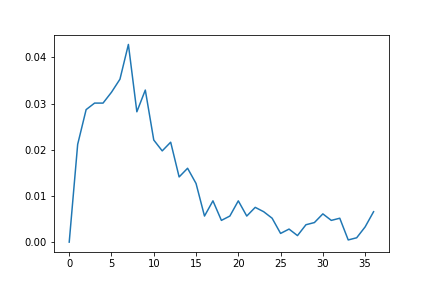

<AxesSubplot:>

In [27]:
%matplotlib notebook
(changes_df_both_d==1).mean(axis=0).plot()